## 1. Importation des données et informations générales

In [21]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import time
from scipy.stats import uniform, randint
import gc
from contextlib import contextmanager


from sklearn.pipeline import Pipeline
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import VarianceThreshold
from sklearn.model_selection import RandomizedSearchCV, train_test_split
from sklearn.metrics import roc_auc_score, roc_curve, confusion_matrix
from sklearn.dummy import DummyClassifier


from lightgbm import LGBMClassifier
from xgboost import XGBClassifier
from catboost import CatBoostClassifier


import joblib
import mlflow
import mlflow.sklearn
import shap


from imblearn.over_sampling import SMOTE


from statsmodels.stats.outliers_influence import variance_inflation_factor

In [22]:
application_test = pd.read_csv('/Users/amira/Documents/OPC/Projet7/projet7/data/application_test.csv', sep=',', encoding='ISO-8859-1')
application_train = pd.read_csv('/Users/amira/Documents/OPC/Projet7/projet7/data/application_train.csv', sep=',', encoding='ISO-8859-1')

In [23]:
# Obtenir la taille et les dimensions
print(f"Taille du DataFrame: {application_train.shape}")

Taille du DataFrame: (307511, 122)


In [24]:
application_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 307511 entries, 0 to 307510
Columns: 122 entries, SK_ID_CURR to AMT_REQ_CREDIT_BUREAU_YEAR
dtypes: float64(65), int64(41), object(16)
memory usage: 286.2+ MB


In [25]:
# Afficher les noms de toutes les colonnes
print(application_train.columns)

Index(['SK_ID_CURR', 'TARGET', 'NAME_CONTRACT_TYPE', 'CODE_GENDER', 'FLAG_OWN_CAR', 'FLAG_OWN_REALTY', 'CNT_CHILDREN', 'AMT_INCOME_TOTAL', 'AMT_CREDIT', 'AMT_ANNUITY',
       ...
       'FLAG_DOCUMENT_18', 'FLAG_DOCUMENT_19', 'FLAG_DOCUMENT_20', 'FLAG_DOCUMENT_21', 'AMT_REQ_CREDIT_BUREAU_HOUR', 'AMT_REQ_CREDIT_BUREAU_DAY', 'AMT_REQ_CREDIT_BUREAU_WEEK', 'AMT_REQ_CREDIT_BUREAU_MON', 'AMT_REQ_CREDIT_BUREAU_QRT', 'AMT_REQ_CREDIT_BUREAU_YEAR'], dtype='object', length=122)


In [26]:
application_test["type_data"]="test"
application_train["type_data"]="train"

## 2. Feature engineering

Feature engineering selon le kernel "LightGBM with Simple Features"

In [27]:
def one_hot_encoder(df, nan_as_category=True):
    original_columns = list(df.columns)
    # Exclure la colonne 'Type_data' des colonnes catégorielles
    categorical_columns = [col for col in df.columns if df[col].dtype == 'object' and col != 'type_data']
    # Encodage one-hot pour les autres colonnes catégorielles
    df = pd.get_dummies(df, columns=categorical_columns, dummy_na=nan_as_category)
    new_columns = [c for c in df.columns if c not in original_columns]
    return df, new_columns

def application_train_test(num_rows=None, nan_as_category=False):
    # Read data and merge
    df = application_train.copy()
    test_df = application_test.copy()

    # Ensure 'TARGET' column exists in test data by filling it with NaN
    test_df['TARGET'] = np.nan

    # Combine train and test datasets
    print("Train samples: {}, test samples: {}".format(len(df), len(test_df)))
    df = pd.concat([df, test_df], axis=0).reset_index(drop=True)

    # Categorical features with Binary encode (0 or 1; two categories)
    for bin_feature in ['CODE_GENDER', 'FLAG_OWN_CAR', 'FLAG_OWN_REALTY']:
        df[bin_feature], uniques = pd.factorize(df[bin_feature])

    # Categorical features with One-Hot encode (excluding 'Type_data')
    df, cat_cols = one_hot_encoder(df, nan_as_category)

    # Assurer que 'Type_data' est bien une colonne catégorielle
    df['type_data'] = df['type_data'].astype('category')

    # NaN values for DAYS_EMPLOYED: 365.243 -> nan
    df['DAYS_EMPLOYED'].replace(365243, np.nan, inplace=True)

    # Some simple new features (percentages)
    df['DAYS_EMPLOYED_PERC'] = df['DAYS_EMPLOYED'] / df['DAYS_BIRTH']
    df['INCOME_CREDIT_PERC'] = df['AMT_INCOME_TOTAL'] / df['AMT_CREDIT']
    df['INCOME_PER_PERSON'] = df['AMT_INCOME_TOTAL'] / df['CNT_FAM_MEMBERS']
    df['ANNUITY_INCOME_PERC'] = df['AMT_ANNUITY'] / df['AMT_INCOME_TOTAL']
    df['PAYMENT_RATE'] = df['AMT_ANNUITY'] / df['AMT_CREDIT']

    # Clean up
    del test_df
    gc.collect()

    return df


# Preprocess bureau.csv and bureau_balance.csv
def bureau_and_balance(num_rows = None, nan_as_category = True):
    bureau = pd.read_csv('/Users/amira/Documents/OPC/Projet7/projet7/data/bureau.csv', sep=',', encoding='ISO-8859-1')
    bb = pd.read_csv('/Users/amira/Documents/OPC/Projet7/projet7/data/bureau_balance.csv', sep=',', encoding='ISO-8859-1')
    bb, bb_cat = one_hot_encoder(bb, nan_as_category)
    bureau, bureau_cat = one_hot_encoder(bureau, nan_as_category)
    
    # Bureau balance: Perform aggregations and merge with bureau.csv
    bb_aggregations = {'MONTHS_BALANCE': ['min', 'max', 'size']}
    for col in bb_cat:
        bb_aggregations[col] = ['mean']
    bb_agg = bb.groupby('SK_ID_BUREAU').agg(bb_aggregations)
    bb_agg.columns = pd.Index([e[0] + "_" + e[1].upper() for e in bb_agg.columns.tolist()])
    bureau = bureau.join(bb_agg, how='left', on='SK_ID_BUREAU')
    bureau.drop(['SK_ID_BUREAU'], axis=1, inplace= True)
    del bb, bb_agg
    gc.collect()
    
    # Bureau and bureau_balance numeric features
    num_aggregations = {
        'DAYS_CREDIT': ['min', 'max', 'mean', 'var'],
        'DAYS_CREDIT_ENDDATE': ['min', 'max', 'mean'],
        'DAYS_CREDIT_UPDATE': ['mean'],
        'CREDIT_DAY_OVERDUE': ['max', 'mean'],
        'AMT_CREDIT_MAX_OVERDUE': ['mean'],
        'AMT_CREDIT_SUM': ['max', 'mean', 'sum'],
        'AMT_CREDIT_SUM_DEBT': ['max', 'mean', 'sum'],
        'AMT_CREDIT_SUM_OVERDUE': ['mean'],
        'AMT_CREDIT_SUM_LIMIT': ['mean', 'sum'],
        'AMT_ANNUITY': ['max', 'mean'],
        'CNT_CREDIT_PROLONG': ['sum'],
        'MONTHS_BALANCE_MIN': ['min'],
        'MONTHS_BALANCE_MAX': ['max'],
        'MONTHS_BALANCE_SIZE': ['mean', 'sum']
    }
    # Bureau and bureau_balance categorical features
    cat_aggregations = {}
    for cat in bureau_cat: cat_aggregations[cat] = ['mean']
    for cat in bb_cat: cat_aggregations[cat + "_MEAN"] = ['mean']
    
    bureau_agg = bureau.groupby('SK_ID_CURR').agg({**num_aggregations, **cat_aggregations})
    bureau_agg.columns = pd.Index(['BURO_' + e[0] + "_" + e[1].upper() for e in bureau_agg.columns.tolist()])
    # Bureau: Active credits - using only numerical aggregations
    active = bureau[bureau['CREDIT_ACTIVE_Active'] == 1]
    active_agg = active.groupby('SK_ID_CURR').agg(num_aggregations)
    active_agg.columns = pd.Index(['ACTIVE_' + e[0] + "_" + e[1].upper() for e in active_agg.columns.tolist()])
    bureau_agg = bureau_agg.join(active_agg, how='left', on='SK_ID_CURR')
    del active, active_agg
    gc.collect()
    # Bureau: Closed credits - using only numerical aggregations
    closed = bureau[bureau['CREDIT_ACTIVE_Closed'] == 1]
    closed_agg = closed.groupby('SK_ID_CURR').agg(num_aggregations)
    closed_agg.columns = pd.Index(['CLOSED_' + e[0] + "_" + e[1].upper() for e in closed_agg.columns.tolist()])
    bureau_agg = bureau_agg.join(closed_agg, how='left', on='SK_ID_CURR')
    del closed, closed_agg, bureau
    gc.collect()
    return bureau_agg

# Preprocess previous_applications.csv
def previous_applications(num_rows = None, nan_as_category = True):
    prev = pd.read_csv('/Users/amira/Documents/OPC/Projet7/projet7/data/previous_application.csv', sep=',', encoding='ISO-8859-1')
    prev, cat_cols = one_hot_encoder(prev, nan_as_category= True)
    # Days 365.243 values -> nan
    prev['DAYS_FIRST_DRAWING'].replace(365243, np.nan, inplace= True)
    prev['DAYS_FIRST_DUE'].replace(365243, np.nan, inplace= True)
    prev['DAYS_LAST_DUE_1ST_VERSION'].replace(365243, np.nan, inplace= True)
    prev['DAYS_LAST_DUE'].replace(365243, np.nan, inplace= True)
    prev['DAYS_TERMINATION'].replace(365243, np.nan, inplace= True)
    # Add feature: value ask / value received percentage
    prev['APP_CREDIT_PERC'] = prev['AMT_APPLICATION'] / prev['AMT_CREDIT']
    # Previous applications numeric features
    num_aggregations = {
        'AMT_ANNUITY': ['min', 'max', 'mean'],
        'AMT_APPLICATION': ['min', 'max', 'mean'],
        'AMT_CREDIT': ['min', 'max', 'mean'],
        'APP_CREDIT_PERC': ['min', 'max', 'mean', 'var'],
        'AMT_DOWN_PAYMENT': ['min', 'max', 'mean'],
        'AMT_GOODS_PRICE': ['min', 'max', 'mean'],
        'HOUR_APPR_PROCESS_START': ['min', 'max', 'mean'],
        'RATE_DOWN_PAYMENT': ['min', 'max', 'mean'],
        'DAYS_DECISION': ['min', 'max', 'mean'],
        'CNT_PAYMENT': ['mean', 'sum'],
    }
    # Previous applications categorical features
    cat_aggregations = {}
    for cat in cat_cols:
        cat_aggregations[cat] = ['mean']
    
    prev_agg = prev.groupby('SK_ID_CURR').agg({**num_aggregations, **cat_aggregations})
    prev_agg.columns = pd.Index(['PREV_' + e[0] + "_" + e[1].upper() for e in prev_agg.columns.tolist()])
    # Previous Applications: Approved Applications - only numerical features
    approved = prev[prev['NAME_CONTRACT_STATUS_Approved'] == 1]
    approved_agg = approved.groupby('SK_ID_CURR').agg(num_aggregations)
    approved_agg.columns = pd.Index(['APPROVED_' + e[0] + "_" + e[1].upper() for e in approved_agg.columns.tolist()])
    prev_agg = prev_agg.join(approved_agg, how='left', on='SK_ID_CURR')
    # Previous Applications: Refused Applications - only numerical features
    refused = prev[prev['NAME_CONTRACT_STATUS_Refused'] == 1]
    refused_agg = refused.groupby('SK_ID_CURR').agg(num_aggregations)
    refused_agg.columns = pd.Index(['REFUSED_' + e[0] + "_" + e[1].upper() for e in refused_agg.columns.tolist()])
    prev_agg = prev_agg.join(refused_agg, how='left', on='SK_ID_CURR')
    del refused, refused_agg, approved, approved_agg, prev
    gc.collect()
    return prev_agg


# Preprocess POS_CASH_balance.csv
def pos_cash(num_rows = None, nan_as_category = True):
    pos= pd.read_csv('/Users/amira/Documents/OPC/Projet7/projet7/data/POS_CASH_balance.csv', sep=',', encoding='ISO-8859-1')
    pos, cat_cols = one_hot_encoder(pos, nan_as_category= True)
    # Features
    aggregations = {
        'MONTHS_BALANCE': ['max', 'mean', 'size'],
        'SK_DPD': ['max', 'mean'],
        'SK_DPD_DEF': ['max', 'mean']
    }
    for cat in cat_cols:
        aggregations[cat] = ['mean']
    
    pos_agg = pos.groupby('SK_ID_CURR').agg(aggregations)
    pos_agg.columns = pd.Index(['POS_' + e[0] + "_" + e[1].upper() for e in pos_agg.columns.tolist()])
    # Count pos cash accounts
    pos_agg['POS_COUNT'] = pos.groupby('SK_ID_CURR').size()
    del pos
    gc.collect()
    return pos_agg
    
# Preprocess installments_payments.csv
def installments_payments(num_rows = None, nan_as_category = True):
    ins = pd.read_csv('/Users/amira/Documents/OPC/Projet7/projet7/data/installments_payments.csv', sep=',', encoding='ISO-8859-1')
    ins, cat_cols = one_hot_encoder(ins, nan_as_category= True)
    # Percentage and difference paid in each installment (amount paid and installment value)
    ins['PAYMENT_PERC'] = ins['AMT_PAYMENT'] / ins['AMT_INSTALMENT']
    ins['PAYMENT_DIFF'] = ins['AMT_INSTALMENT'] - ins['AMT_PAYMENT']
    # Days past due and days before due (no negative values)
    ins['DPD'] = ins['DAYS_ENTRY_PAYMENT'] - ins['DAYS_INSTALMENT']
    ins['DBD'] = ins['DAYS_INSTALMENT'] - ins['DAYS_ENTRY_PAYMENT']
    ins['DPD'] = ins['DPD'].apply(lambda x: x if x > 0 else 0)
    ins['DBD'] = ins['DBD'].apply(lambda x: x if x > 0 else 0)
    # Features: Perform aggregations
    aggregations = {
        'NUM_INSTALMENT_VERSION': ['nunique'],
        'DPD': ['max', 'mean', 'sum'],
        'DBD': ['max', 'mean', 'sum'],
        'PAYMENT_PERC': ['max', 'mean', 'sum', 'var'],
        'PAYMENT_DIFF': ['max', 'mean', 'sum', 'var'],
        'AMT_INSTALMENT': ['max', 'mean', 'sum'],
        'AMT_PAYMENT': ['min', 'max', 'mean', 'sum'],
        'DAYS_ENTRY_PAYMENT': ['max', 'mean', 'sum']
    }
    for cat in cat_cols:
        aggregations[cat] = ['mean']
    ins_agg = ins.groupby('SK_ID_CURR').agg(aggregations)
    ins_agg.columns = pd.Index(['INSTAL_' + e[0] + "_" + e[1].upper() for e in ins_agg.columns.tolist()])
    # Count installments accounts
    ins_agg['INSTAL_COUNT'] = ins.groupby('SK_ID_CURR').size()
    del ins
    gc.collect()
    return ins_agg

# Preprocess credit_card_balance.csv
def credit_card_balance(num_rows = None, nan_as_category = True):
    cc= pd.read_csv('/Users/amira/Documents/OPC/Projet7/projet7/data/credit_card_balance.csv', sep=',', encoding='ISO-8859-1')
    cc, cat_cols = one_hot_encoder(cc, nan_as_category= True)
    # General aggregations
    cc.drop(['SK_ID_PREV'], axis= 1, inplace = True)
    cc_agg = cc.groupby('SK_ID_CURR').agg(['min', 'max', 'mean', 'sum', 'var'])
    cc_agg.columns = pd.Index(['CC_' + e[0] + "_" + e[1].upper() for e in cc_agg.columns.tolist()])
    # Count credit card lines
    cc_agg['CC_COUNT'] = cc.groupby('SK_ID_CURR').size()
    del cc
    gc.collect()
    return cc_agg


Fusionnement des différents jeux de données

In [28]:
train_test_df = application_train_test()           # application_train.csv et application_test.csv
bureau_agg_df = bureau_and_balance()               # bureau.csv et bureau_balance.csv
prev_app_agg_df = previous_applications()          # previous_application.csv
pos_cash_agg_df = pos_cash()                       # POS_CASH_balance.csv
installments_agg_df = installments_payments()      # installments_payments.csv
credit_card_agg_df = credit_card_balance()         # credit_card_balance.csv

# Le DataFrame principal est `train_test_df`, et nous fusionnons chaque ensemble basé sur `SK_ID_CURR`.
train_test_df = train_test_df.merge(bureau_agg_df, on='SK_ID_CURR', how='left')
train_test_df = train_test_df.merge(prev_app_agg_df, on='SK_ID_CURR', how='left')
train_test_df = train_test_df.merge(pos_cash_agg_df, on='SK_ID_CURR', how='left')
train_test_df = train_test_df.merge(installments_agg_df, on='SK_ID_CURR', how='left')
train_test_df = train_test_df.merge(credit_card_agg_df, on='SK_ID_CURR', how='left')

Train samples: 307511, test samples: 48744


Vérification des valeurs uniques de SK_ID_CURR

In [29]:
unique_values = train_df['SK_ID_CURR'].nunique()

total_values = len(train_df['SK_ID_CURR'])

if unique_values == total_values:
    print("Toutes les valeurs de SK_ID_CURR sont uniques.")
else:
    print(f"Il y a {total_values - unique_values} doublons dans SK_ID_CURR.")

Toutes les valeurs de SK_ID_CURR sont uniques.


In [30]:
# Séparer le DataFrame selon la colonne 'Type_data'
train_df = train_test_df[train_test_df['type_data'] == 'train']
test_df = train_test_df[train_test_df['type_data'] == 'test']

# Supprimer la colonne 'Type_data' des deux DataFrames
train_df = train_df.drop(columns=['type_data'])
test_df = test_df.drop(columns=['type_data'])

# Afficher les formes des nouveaux DataFrames pour vérifier
print("Train DataFrame shape:", train_df.shape)
print("Test DataFrame shape:", test_df.shape)

Train DataFrame shape: (307511, 797)
Test DataFrame shape: (48744, 797)


In [31]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 307511 entries, 0 to 307510
Columns: 797 entries, SK_ID_CURR to CC_COUNT
dtypes: float64(622), int64(42), uint8(133)
memory usage: 1.6 GB


## 3. EDA

### 3.1. Variable cible TARGET

Etude de la distribution de la variable TARGET

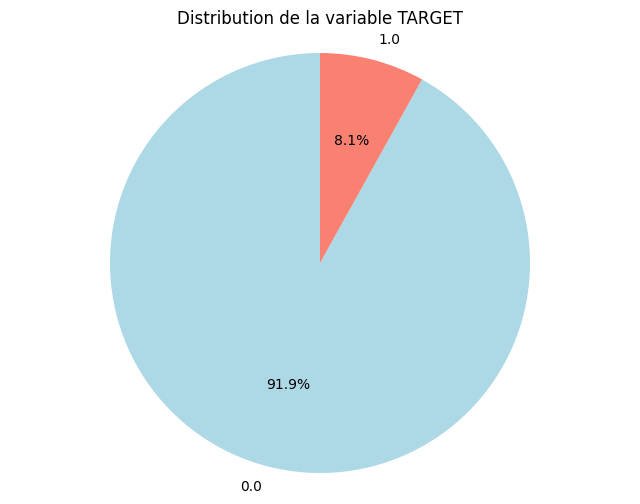

In [32]:
target_distribution = train_df['TARGET'].value_counts()

plt.figure(figsize=(8, 6))
plt.pie(target_distribution, labels=target_distribution.index, autopct='%1.1f%%', startangle=90, colors=['lightblue', 'salmon'])
plt.title('Distribution de la variable TARGET')
plt.axis('equal')  
plt.show()

Ces données indiquent un problème de déséquilibre pour la variable Target, avec un nombre nettement supérieur de prêts remboursés à temps (91.9%) par rapport aux prêts non remboursés (8.1%). Pour corriger ce déséquilibre lors de l'utilisation de modèles d'apprentissage automatique plus avancés, nous pourrons ajuster la pondération des classes en fonction de leur fréquence dans les données avec la méthode SMOTE.

### 3.2. Corrélations

Sélection de variables pour un modèle de machine learning, en utilisant des techniques basées sur la corrélation et le Variance Inflation Factor (VIF) pour sélectionner les variables corrélées avec la variable TARGET et éliminer les variables redondantes ou multicolinéaires

In [33]:
# Calculer les corrélations avec la variable TARGET
corr_with_target = train_df.corr()['TARGET'].sort_values(ascending=False)

# Filtrer les variables ayant une corrélation significative avec TARGET
threshold = 0.05  
significant_vars = corr_with_target[abs(corr_with_target) > threshold].index.tolist()

# Créer un sous-ensemble du DataFrame avec ces variables
df_significant = train_df[significant_vars]

# Calculer la matrice de corrélation pour ces variables
corr_matrix = df_significant.corr().abs()

# Supprimer les variables corrélées entre elles 
upper_tri = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))

# Trouver les variables ayant une corrélation supérieure au seuil
to_drop = [column for column in upper_tri.columns if any(upper_tri[column] > 0.7)]

# Supprimer les variables corrélées entre elles
df_reduced = df_significant.drop(columns=to_drop)

# Créer un DataFrame sans valeurs manquantes pour le calcul du VIF
X = df_reduced.dropna().assign(constant=1)

# Calculer les VIF pour chaque variable sur les données sans valeurs manquantes
vif_data = pd.DataFrame()
vif_data["feature"] = X.columns
vif_data["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]

# Filtrer les variables ayant un VIF élevé 
final_vars = vif_data[vif_data['VIF'] < 5]['feature'].tolist()

# Supprimer la constante du résultat final si présente
if 'constant' in final_vars:
    final_vars.remove('constant')

# Les variables finales sélectionnées
print("Variables sélectionnées :", final_vars)

# Créer un dataframe qui regroupe les variables sélectionnées
train_df_2 = train_df[final_vars]

Variables sélectionnées : ['TARGET', 'CC_CNT_DRAWINGS_ATM_CURRENT_MEAN', 'CC_CNT_DRAWINGS_CURRENT_MAX', 'BURO_DAYS_CREDIT_MEAN', 'CC_AMT_BALANCE_MEAN', 'DAYS_BIRTH', 'PREV_NAME_CONTRACT_STATUS_Refused_MEAN', 'BURO_CREDIT_ACTIVE_Active_MEAN', 'DAYS_EMPLOYED', 'REFUSED_DAYS_DECISION_MAX', 'CC_AMT_BALANCE_MIN', 'ACTIVE_DAYS_CREDIT_MEAN', 'CC_CNT_DRAWINGS_ATM_CURRENT_MAX', 'CC_MONTHS_BALANCE_MEAN', 'BURO_STATUS_1_MEAN_MEAN', 'CC_CNT_DRAWINGS_ATM_CURRENT_VAR', 'REGION_RATING_CLIENT_W_CITY', 'CC_AMT_DRAWINGS_CURRENT_MEAN', 'NAME_INCOME_TYPE_Working', 'PREV_NAME_PRODUCT_TYPE_walk-in_MEAN', 'PREV_CODE_REJECT_REASON_SCOFR_MEAN', 'DAYS_LAST_PHONE_CHANGE', 'APPROVED_DAYS_DECISION_MIN', 'DAYS_ID_PUBLISH', 'REG_CITY_NOT_WORK_CITY', 'REFUSED_HOUR_APPR_PROCESS_START_MIN', 'CODE_GENDER', 'BURO_STATUS_C_MEAN_MEAN', 'NAME_EDUCATION_TYPE_Higher education', 'PREV_NAME_CONTRACT_STATUS_Approved_MEAN', 'EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3']


Matrice de corrélation du jeu train_df_2, soit le dataframe qui regroupe les variables sélectionnées

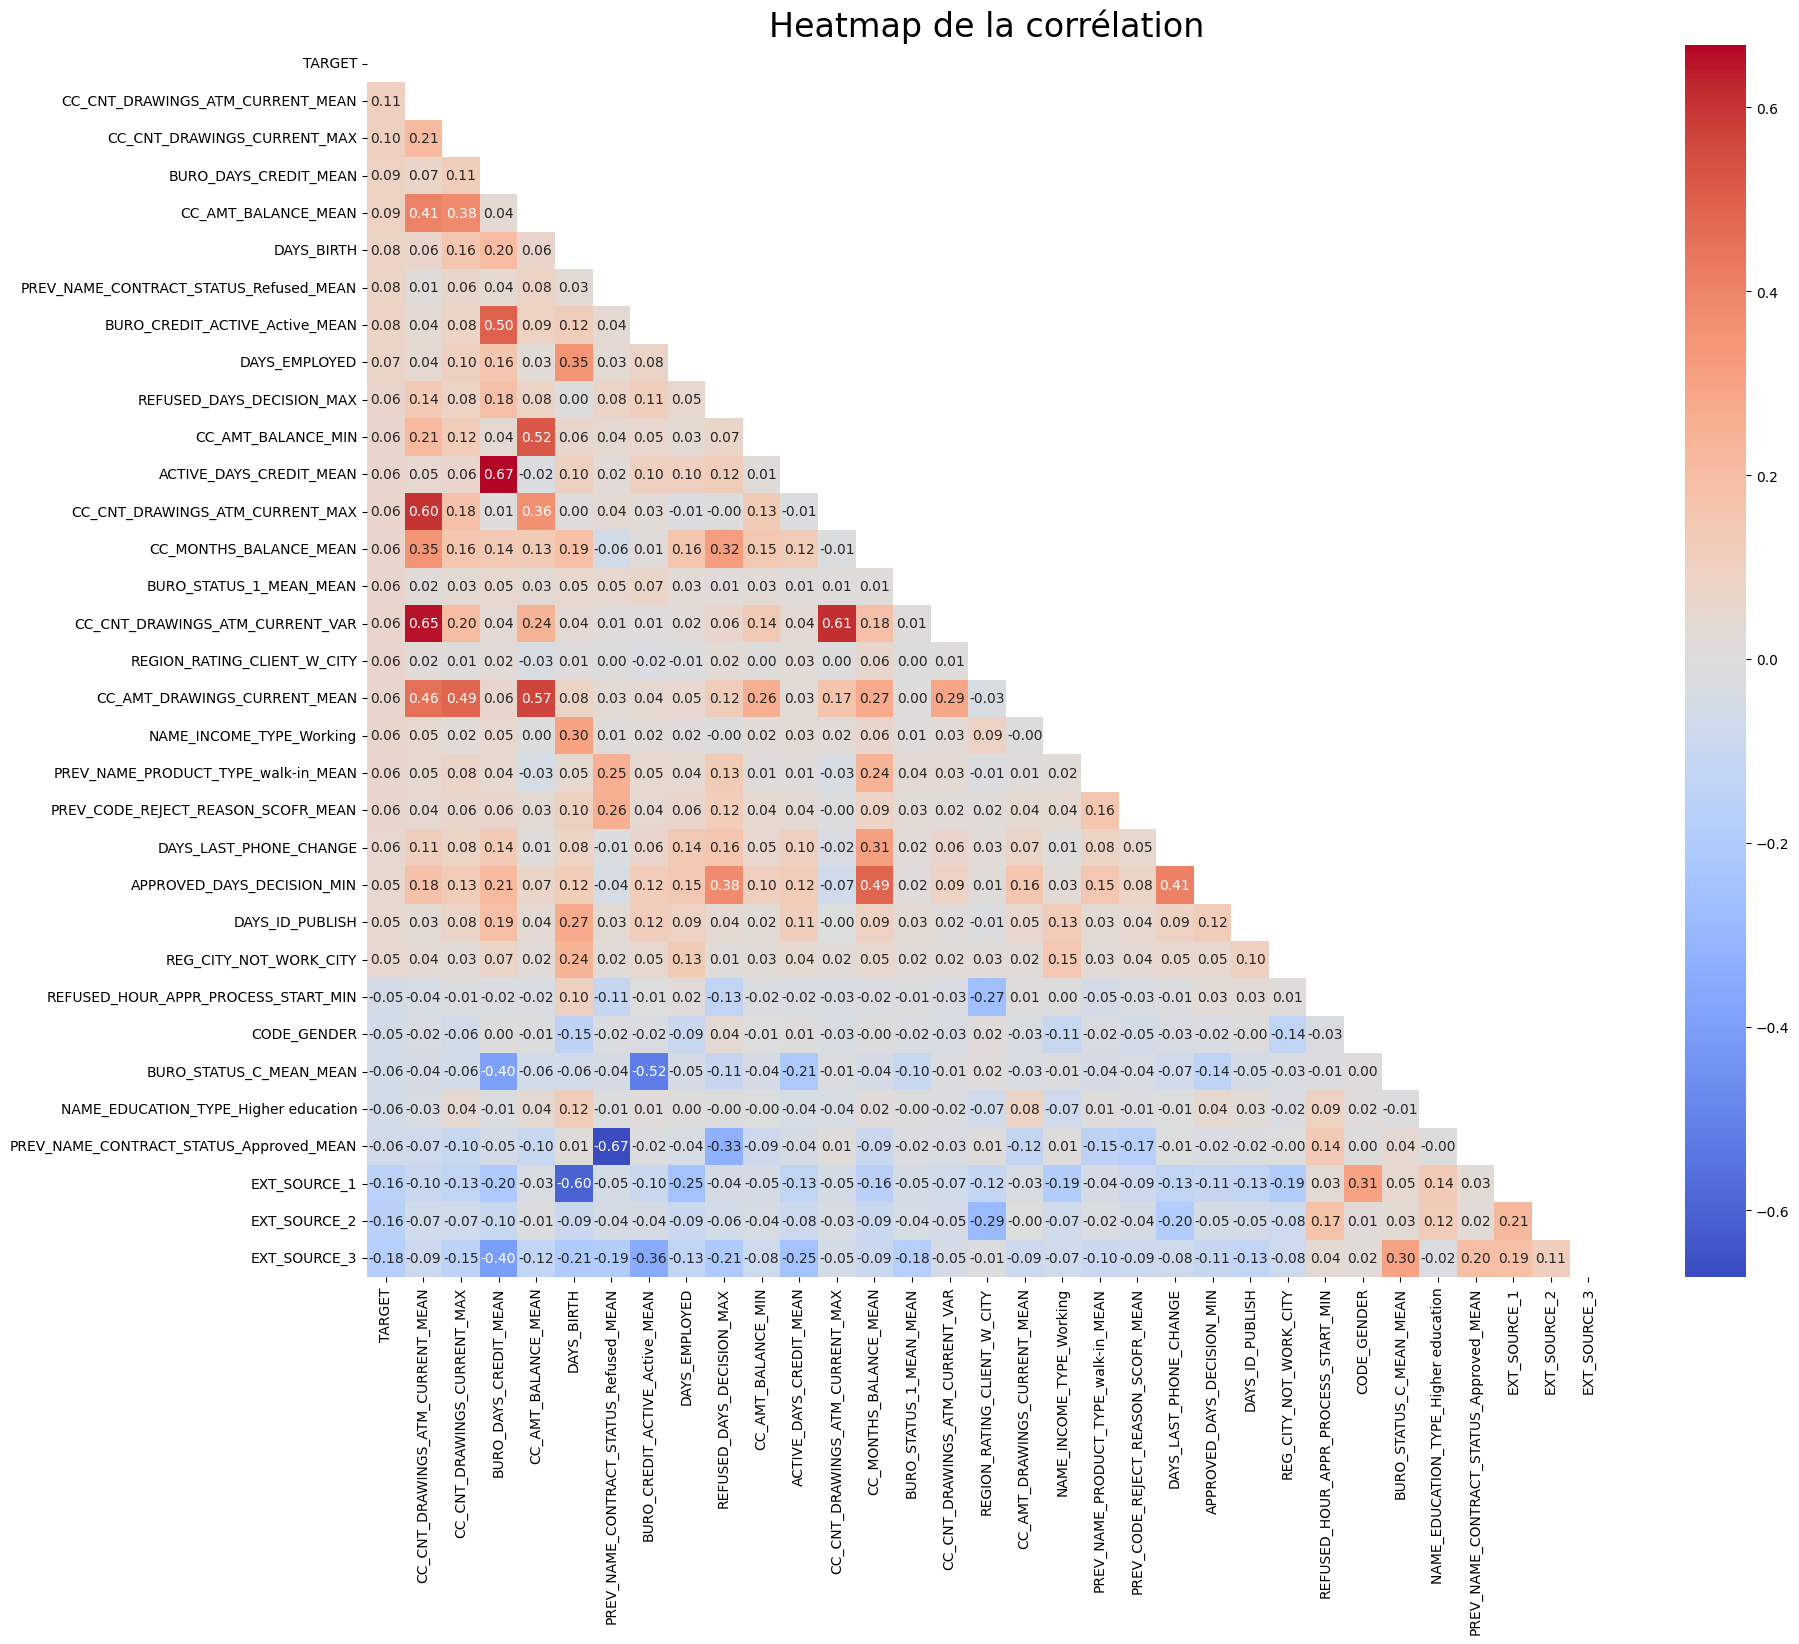

In [34]:
# Calculer la matrice de corrélation pour les variables sélectionnées
corr_matrix_2 = train_df_2.corr()

# Masquer la moitié inférieure de la matrice de corrélation
mask = np.triu(np.ones_like(corr_matrix_2, dtype=bool))

# Tracer la heatmap avec le masque
plt.figure(figsize=(20, 16))
sns.heatmap(corr_matrix_2, mask=mask, annot=True, cmap='coolwarm', fmt='.2f', cbar=True)
plt.title("Heatmap de la corrélation", fontsize=24)
plt.show()

### 3.3. Description du dataframe trié

#### 3.3.1. Informations générales

In [35]:
train_df_2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 307511 entries, 0 to 307510
Data columns (total 33 columns):
 #   Column                                   Non-Null Count   Dtype  
---  ------                                   --------------   -----  
 0   TARGET                                   307511 non-null  float64
 1   CC_CNT_DRAWINGS_ATM_CURRENT_MEAN         61140 non-null   float64
 2   CC_CNT_DRAWINGS_CURRENT_MAX              86905 non-null   float64
 3   BURO_DAYS_CREDIT_MEAN                    263491 non-null  float64
 4   CC_AMT_BALANCE_MEAN                      86905 non-null   float64
 5   DAYS_BIRTH                               307511 non-null  int64  
 6   PREV_NAME_CONTRACT_STATUS_Refused_MEAN   291057 non-null  float64
 7   BURO_CREDIT_ACTIVE_Active_MEAN           263491 non-null  float64
 8   DAYS_EMPLOYED                            252137 non-null  float64
 9   REFUSED_DAYS_DECISION_MAX                100294 non-null  float64
 10  CC_AMT_BALANCE_MIN              

In [36]:
pd.set_option('display.max_columns', None)  
pd.set_option('display.width', 1000)  
train_df_2.describe()

,TARGET,CC_CNT_DRAWINGS_ATM_CURRENT_MEAN,CC_CNT_DRAWINGS_CURRENT_MAX,BURO_DAYS_CREDIT_MEAN,CC_AMT_BALANCE_MEAN,DAYS_BIRTH,PREV_NAME_CONTRACT_STATUS_Refused_MEAN,BURO_CREDIT_ACTIVE_Active_MEAN,DAYS_EMPLOYED,REFUSED_DAYS_DECISION_MAX,CC_AMT_BALANCE_MIN,ACTIVE_DAYS_CREDIT_MEAN,CC_CNT_DRAWINGS_ATM_CURRENT_MAX,CC_MONTHS_BALANCE_MEAN,BURO_STATUS_1_MEAN_MEAN,CC_CNT_DRAWINGS_ATM_CURRENT_VAR,REGION_RATING_CLIENT_W_CITY,CC_AMT_DRAWINGS_CURRENT_MEAN,NAME_INCOME_TYPE_Working,PREV_NAME_PRODUCT_TYPE_walk-in_MEAN,PREV_CODE_REJECT_REASON_SCOFR_MEAN,DAYS_LAST_PHONE_CHANGE,APPROVED_DAYS_DECISION_MIN,DAYS_ID_PUBLISH,REG_CITY_NOT_WORK_CITY,REFUSED_HOUR_APPR_PROCESS_START_MIN,CODE_GENDER,BURO_STATUS_C_MEAN_MEAN,NAME_EDUCATION_TYPE_Higher education,PREV_NAME_CONTRACT_STATUS_Approved_MEAN,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3
count,307511.000000,61140.000000,86905.000000,263491.000000,86905.000000,307511.000000,291057.000000,263491.000000,252137.000000,100294.000000,86905.000000,217150.000000,61140.000000,86905.000000,92231.000000,60693.000000,307511.000000,8.690500e+04,307511.000000,291057.000000,291057.00000,307510.000000,290065.000000,307511.000000,307511.000000,100294.000000,307511.000000,92231.000000,307511.000000,291057.000000,134133.000000,3.068510e+05,246546.000000
mean,0.080729,0.566241,6.803625,-1083.047110,71459.926952,-16036.995067,0.110902,0.412972,-2384.169325,-728.625042,10807.899707,-650.789789,3.995895,-19.523150,0.014199,2.040586,2.031521,1.391348e+04,0.516320,0.080552,0.00562,-962.858788,-1530.571334,-2994.202373,0.230454,11.603845,0.658370,0.330249,0.243448,0.748855,0.502130,5.143927e-01,0.510853
std,0.272419,0.880410,10.572428,563.327298,109056.518226,4363.988632,0.184348,0.308404,2338.360162,746.190402,45122.149552,495.737551,3.639161,16.775910,0.041683,6.686411,0.502737,2.661058e+04,0.499734,0.183439,0.04314,826.808487,862.867945,1509.450419,0.421124,3.309328,0.474284,0.262989,0.429164,0.262332,0.211062,1.910602e-01,0.194844
min,0.000000,0.000000,0.000000,-2922.000000,-2930.232558,-25229.000000,0.000000,0.000000,-17912.000000,-2922.000000,-420250.185000,-2922.000000,0.000000,-50.179775,0.000000,0.000000,1.000000,0.000000e+00,0.000000,0.000000,0.00000,-4292.000000,-2922.000000,-7197.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.014568,8.173617e-08,0.000527
25%,0.000000,0.062993,0.000000,-1434.000000,0.000000,-19682.000000,0.000000,0.200000,-3175.000000,-1004.000000,0.000000,-871.500000,2.000000,-38.500000,0.000000,0.115351,2.000000,0.000000e+00,0.000000,0.000000,0.00000,-1570.000000,-2379.000000,-4299.000000,0.000000,9.000000,0.000000,0.093333,0.000000,0.500000,0.334007,3.924574e-01,0.370650
50%,0.000000,0.270833,3.000000,-1050.571429,26793.606316,-15750.000000,0.000000,0.375000,-1648.000000,-396.000000,0.000000,-537.309524,3.000000,-12.000000,0.000000,0.553571,2.000000,3.473672e+03,1.000000,0.000000,0.00000,-757.000000,-1490.000000,-3254.000000,0.000000,11.000000,1.000000,0.308514,0.000000,0.800000,0.505998,5.659614e-01,0.535276
75%,0.000000,0.731343,8.000000,-663.763889,98610.502500,-12413.000000,0.200000,0.600000,-767.000000,-213.000000,0.000000,-294.425000,6.000000,-6.000000,0.008333,1.714286,2.000000,1.833400e+04,1.000000,0.000000,0.00000,-274.000000,-720.000000,-1720.000000,0.000000,14.000000,1.000000,0.521270,0.000000,1.000000,0.675053,6.636171e-01,0.669057
max,1.000000,35.000000,165.000000,0.000000,928686.323571,-7489.000000,1.000000,1.000000,0.000000,-2.000000,869873.535000,0.000000,51.000000,-1.000000,0.833333,462.250000,3.000000,1.125000e+06,1.000000,1.000000,1.00000,0.000000,-2.000000,0.000000,1.000000,23.000000,2.000000,1.000000,1.000000,1.000000,0.962693,8.549997e-01,0.896010


In [37]:
types_df = pd.DataFrame(train_df_2.dtypes).reset_index()
types_df.columns = ['Column Name', 'Data Type']
types_df

,Column Name,Data Type
0,TARGET,float64
1,CC_CNT_DRAWINGS_ATM_CURRENT_MEAN,float64
2,CC_CNT_DRAWINGS_CURRENT_MAX,float64
3,BURO_DAYS_CREDIT_MEAN,float64
4,CC_AMT_BALANCE_MEAN,float64
5,DAYS_BIRTH,int64
6,PREV_NAME_CONTRACT_STATUS_Refused_MEAN,float64
7,BURO_CREDIT_ACTIVE_Active_MEAN,float64
8,DAYS_EMPLOYED,float64
9,REFUSED_DAYS_DECISION_MAX,float64


#### 3.3.2. Valeurs manquantes

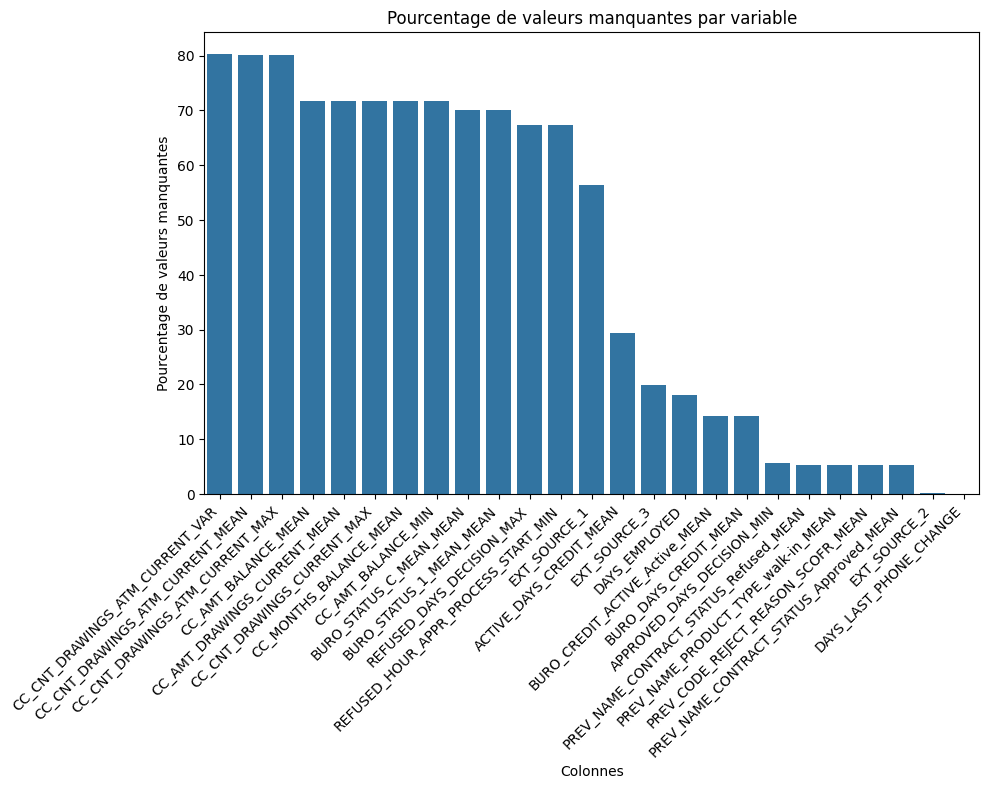

In [38]:
# Calculer le nombre de valeurs manquantes pour chaque colonne
missing_values = train_df_2.isnull().sum()

# Calculer le pourcentage de valeurs manquantes pour chaque colonne
missing_percentage = 100 * missing_values / len(train_df_2)

# Créer un DataFrame avec le nombre et le pourcentage de valeurs manquantes
missing_df = pd.DataFrame({'Missing Values': missing_values, 'Pourc of Total Values': missing_percentage})

# Trier les colonnes par pourcentage de valeurs manquantes en ordre décroissant
missing_df_sorted = missing_df[missing_df['Missing Values'] > 0].sort_values('Pourc of Total Values', ascending=False).round(2)

# Créer un diagramme en barres avec Seaborn pour les valeurs manquantes
plt.figure(figsize=(10, 6))
sns.barplot(x=missing_df_sorted.index, y=missing_df_sorted['Pourc of Total Values'])
plt.xticks(rotation=45, ha='right')  
plt.xlabel('Colonnes')
plt.ylabel('Pourcentage de valeurs manquantes')
plt.title('Pourcentage de valeurs manquantes par variable')
plt.show()


In [39]:
# Calcul du pourcentage global de valeurs manquantes
missing_percentage = train_df_2.isnull().sum().sum() / train_df_2.size * 100
print(f"Pourcentage global de valeurs manquantes : {missing_percentage:.2f}%")


Pourcentage global de valeurs manquantes : 31.92%


Avant de passer à la phase d’entraînement des modèles, il sera crucial de traiter les colonnes avec des valeurs manquantes afin de garantir la qualité des données et d'améliorer les performances du modèle.

#### 3.3.3. Valeurs nulles

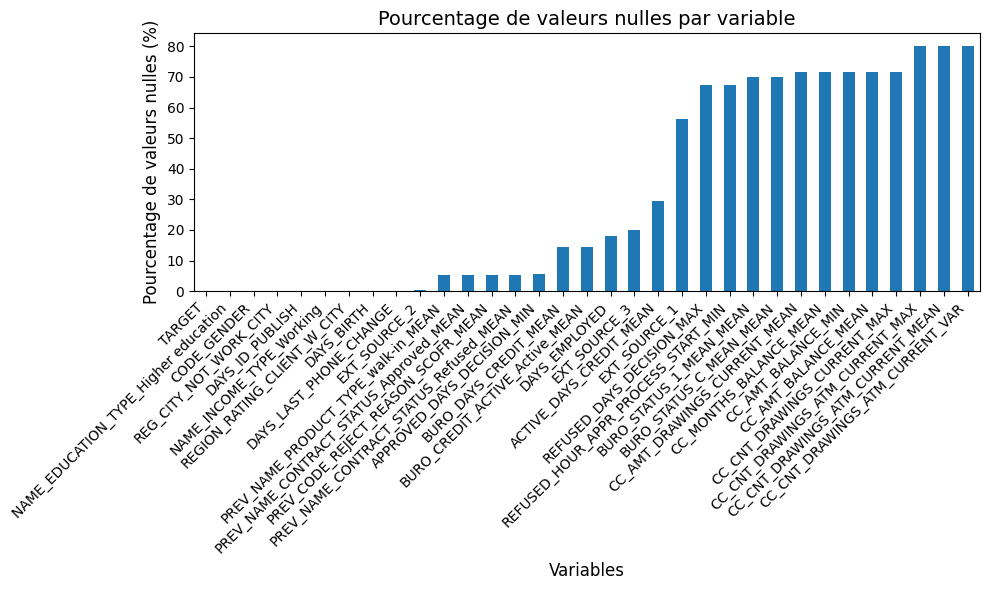

In [40]:
# Calculer le pourcentage de valeurs nulles par colonne
null_percentages = train_df_2.isnull().mean() * 100

# Trier les pourcentages par ordre croissant
null_percentages_sorted = null_percentages.sort_values()

# Tracer l'histogramme avec les données triées
plt.figure(figsize=(10, 6))
null_percentages_sorted.plot(kind='bar')
plt.xlabel('Variables', fontsize=12)
plt.ylabel('Pourcentage de valeurs nulles (%)', fontsize=12)
plt.title('Pourcentage de valeurs nulles par variable', fontsize=14)
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

## 4. Modèles de prédiction

Exécution d'un workflow complet de machine learning pour le projet de scoring de crédit, en utilisant plusieurs modèles, en optimisant les hyperparamètres et en évaluant les résultats avec des plusieurs métriques

### 4.1. Prétraitement des données

- Séparation des variables et de la cible TARGET
- Division des données en 3 ensembles:
    - Entraînement (80%)
    - Validation (10%)
    - Test (10%)
- Imputation des valeurs manquantes par la médiane (nécessaire pour l'utilisation de SMOTE et pour le fonctionnement de certains modèles)
- Gestion du déséquilibre de la distribution de la variable TARGET par la méthode SMOTE (génération de données synthétiques pour la classe minoritaire TARGET = 1)
- Normalisation des données avec MinMaxScaler

In [41]:
# Séparation des caractéristiques (X) et de la cible (y) pour l'entraînement
X = train_df_2.drop(columns='TARGET')
y = train_df_2['TARGET']

# Séparation du jeu d'entraînement en entraînement et validation (80% - 20%)
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.2, random_state=42)

# Séparation de X_temp en validation et test (50% - 50% de l'ensemble temp)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

# Sélectionner uniquement les colonnes quantitatives
quantitative_columns = X_train.select_dtypes(include=[np.number]).columns

# Initialiser l'imputer avec la stratégie 'median'
imputer = SimpleImputer(strategy='median')

# Appliquer l'imputer sur les colonnes quantitatives des jeux de données
X_train[quantitative_columns] = imputer.fit_transform(X_train[quantitative_columns])
X_val[quantitative_columns] = imputer.transform(X_val[quantitative_columns])
X_test[quantitative_columns] = imputer.transform(X_test[quantitative_columns])

# Application de SMOTE uniquement sur le jeu d'entraînement pour gérer le déséquilibre des classes
smote = SMOTE(random_state=42)
X_train, y_train = smote.fit_resample(X_train, y_train)

# Standardiser les données avec MinMaxScaler
scaler = StandardScaler()

# Appliquer la standardisation sur les jeux de données
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)
X_test = scaler.transform(X_test)

# Vérification des dimensions
print(f"Dimensions de X_train : {X_train.shape}")
print(f"Dimensions de X_val : {X_val.shape}")
print(f"Dimensions de X_test : {X_test.shape}")

Dimensions de X_train : (452264, 32)
Dimensions de X_val : (30751, 32)
Dimensions de X_test : (30752, 32)


Enregistrement des données train et en production pour le data drift

In [42]:
quantitative_columns = train_df_2.select_dtypes(include=[np.number]).columns.tolist()

# Exclure 'TARGET' de la liste si elle est présente
if 'TARGET' in quantitative_columns:
    quantitative_columns.remove('TARGET')

# Afficher la liste des colonnes quantitatives
len(quantitative_columns)

32

In [44]:
# Convertir X_train en DataFrames et réassigner les colonnes d'origine
X_train_df = pd.DataFrame(X_train, columns=quantitative_columns)

# Sauvegarder en fichier CSV
X_train_df.to_csv('/Users/amira/Documents/OPC/Projet7/projet7/data/train_data.csv', index=False)

# Supprimer de la colonne TARGET et d'autres colonnes inutiles comme SK_ID_CURR 
test_df = test_df.drop(columns=['SK_ID_CURR', 'TARGET'], errors='ignore')

# Copie du jeu de données de production
X_production = test_df.copy()

# Reindexer les colonnes pour correspondre aux colonnes quantitatives de l'entraînement
X_production = X_production.reindex(columns=quantitative_columns)

# Appliquer l'imputer ajusté sur les colonnes quantitatives
X_production[quantitative_columns] = imputer.transform(X_production[quantitative_columns])

# Appliquer le scaler ajusté sur les colonnes quantitatives
X_production[quantitative_columns] = scaler.transform(X_production[quantitative_columns])

# Enregistrer les données prétraitées en CSV
X_production.to_csv('/Users/amira/Documents/OPC/Projet7/projet7/data/production_data.csv', index=False)

print("Les fichiers CSV ont été générés et enregistrés avec succès.")

Les fichiers CSV ont été générés et enregistrés avec succès.


### 4.2. Modélisation

- Définition d'une fonction métier (business_score) pour évaluer le coût métier d'une prédiction en prenant en compte les faux négatifs et faux positifs, afin de calculer un coût personnalisé en fonction des erreurs de prédiction
- Choix de plusieurs modèles (linéaire et non-linéaire) à tester:
    - Régression logistique
    - LightGBM
    - XGBoost
    - CatBoost
    - DummyClassifier (un modèle de référence pour comparer les performances)
- Evaluation et optimisation des modèles avec RandomizedSearchCV. Les métriques choisies sont:
    - AUC: mesure la qualité des prédictions.
    - Business Cost: coût des erreurs métier
    - Temps d'exécution
- Suivi des expériences avec MLflow, avec enregistrement des hyperparamètres, des modèles et des métriques dans un environnement d'expérimentation
- Modèle optimal (càd celui qui minimise le coût métier) est ensuite ré-entraîné sur l'ensemble complet des données d'entraînement, et évalué sur le jeu de test
- Sélection des performances du modèle optimal avec le jeu de test en utilisant le seuil optimal trouvé précédemment et détermination des métriques finales 

In [45]:


# Fonction pour calculer le score métier
def business_score(y_true, y_pred_proba, threshold=0.5, fn_cost=10, fp_cost=1):
    y_pred = (y_pred_proba >= threshold).astype(int)
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    total_cost = (fn * fn_cost) + (fp * fp_cost)
    return total_cost

# Fonction pour évaluer les modèles
def evaluate_model(model, X_train, y_train, X_val, y_val, threshold=0.5):
    start_time = time.time()
    model.fit(X_train, y_train)
    y_val_pred_proba = model.predict_proba(X_val)[:, 1]

    auc_score = round(roc_auc_score(y_val, y_val_pred_proba), 3)  
    business_cost = business_score(y_val, y_val_pred_proba, threshold=threshold)
    exec_time = round(time.time() - start_time, 3)  

    return {
        'AUC': auc_score,
        'Business Cost': business_cost,
        'Execution Time': exec_time
    }

# Fonction pour optimiser le seuil
def find_optimal_threshold(model, X_val, y_val, fn_cost=10, fp_cost=1):
    best_threshold = 0.5
    best_cost = float('inf')
    
    y_val_pred_proba = model.predict_proba(X_val)[:, 1]
    
    for threshold in np.arange(0, 1, 0.01):
        cost = business_score(y_val, y_val_pred_proba, threshold, fn_cost, fp_cost)
        if cost < best_cost:
            best_cost = cost
            best_threshold = threshold
    
    return best_threshold, best_cost

# Modèles à tester
models = {
    'DummyClassifier': DummyClassifier(strategy='stratified'),
    'LogisticRegression': LogisticRegression(max_iter=1000),
    'LightGBM': LGBMClassifier(),
    'XGBoost': XGBClassifier(eval_metric='auc'),
    'CatBoost': CatBoostClassifier(silent=True)
}

# Paramètres à tester pour chaque modèle avec RandomizedSearchCV
param_dist = {
    'DummyClassifier': {
        'strategy': ['stratified', 'most_frequent']
    },
    'LogisticRegression': {
        'C': uniform(0.01, 10),  
        'solver': ['lbfgs', 'liblinear']
    },
    'LightGBM': {
        'num_leaves': randint(20, 50),
        'learning_rate': uniform(0.01, 0.3),
        'n_estimators': randint(100, 200)
    },
    'XGBoost': {
        'learning_rate': uniform(0.01, 0.3),
        'n_estimators': randint(100, 200),
        'max_depth': randint(3, 10)
    },
    'CatBoost': {
        'depth': randint(3, 10),
        'learning_rate': uniform(0.01, 0.3),
        'iterations': randint(100, 200)
    }
}

# DataFrame pour stocker les résultats
results = []

# Boucle sur les modèles
for model_name, model in models.items():
    print(f"Optimisation pour {model_name}")
    
    # RandomizedSearchCV pour optimiser les hyperparamètres
    search_cv = RandomizedSearchCV(
        model,
        param_distributions=param_dist[model_name],
        n_iter=10,
        cv=3,
        n_jobs=-1,  # Utiliser tous les cœurs disponibles
        random_state=42
    )
    
    search_cv.fit(X_train, y_train)
    best_model = search_cv.best_estimator_
    
    # Évaluer les métriques
    eval_metrics = evaluate_model(best_model, X_train, y_train, X_val, y_val)
    best_threshold, best_cost = find_optimal_threshold(best_model, X_val, y_val)
    eval_metrics['Optimal Threshold'] = best_threshold
    eval_metrics['Business Cost with Optimal Threshold'] = best_cost
    eval_metrics['Model'] = model_name
    eval_metrics['Best Params'] = search_cv.best_params_
    
    results.append(eval_metrics)

# Rassembler les résultats dans un DataFrame
df_results = pd.DataFrame(results)

# Afficher les résultats
df_results

Optimisation pour DummyClassifier


/opt/anaconda3/lib/python3.11/site-packages/sklearn/model_selection/_search.py:320: UserWarning: The total space of parameters 2 is smaller than n_iter=10. Running 2 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Optimisation pour LogisticRegression


/opt/anaconda3/lib/python3.11/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


Optimisation pour LightGBM
[LightGBM] [Info] Number of positive: 150755, number of negative: 150755
[LightGBM] [Info] Number of positive: 150755, number of negative: 150754
[LightGBM] [Info] Number of positive: 150755, number of negative: 150754
[LightGBM] [Info] Number of positive: 150754, number of negative: 150755
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.613532 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 8147
[LightGBM] [Info] Number of data points in the train set: 301510, number of used features: 32
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.241267 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 

/opt/anaconda3/lib/python3.11/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


Optimisation pour CatBoost


,AUC,Business Cost,Execution Time,Optimal Threshold,Business Cost with Optimal Threshold,Model,Best Params
0,0.506,26263,0.195,0.01,26753,DummyClassifier,{'strategy': 'stratified'}
1,0.742,17101,1.012,0.53,16951,LogisticRegression,"{'C': 3.7554011884736247, 'solver': 'lbfgs'}"
2,0.726,24048,12.865,0.09,17572,LightGBM,"{'learning_rate': 0.22959818254342154, 'n_esti..."
3,0.727,23913,15.417,0.09,17594,XGBoost,"{'learning_rate': 0.16743239807751675, 'max_de..."
4,0.725,24016,39.859,0.12,17467,CatBoost,"{'depth': 9, 'iterations': 151, 'learning_rate..."


In [19]:
# Fonction pour calculer le score métier
def business_score(y_true, y_pred_proba, threshold=0.5, fn_cost=10, fp_cost=1):
    y_pred = (y_pred_proba >= threshold).astype(int)
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    total_cost = (fn * fn_cost) + (fp * fp_cost)
    return total_cost

# Fonction pour évaluer les modèles
def evaluate_model(model, X_train, y_train, X_val, y_val, threshold=0.5):
    start_time = time.time()
    model.fit(X_train, y_train)
    y_val_pred_proba = model.predict_proba(X_val)[:, 1]

    auc_score = round(roc_auc_score(y_val, y_val_pred_proba), 3)  
    business_cost = business_score(y_val, y_val_pred_proba, threshold=threshold)
    exec_time = round(time.time() - start_time, 3)  

    return {
        'AUC': auc_score,
        'Business Cost': business_cost,
        'Execution Time': exec_time
    }

# Fonction pour optimiser le seuil
def find_optimal_threshold(model, X_val, y_val, fn_cost=10, fp_cost=1):
    best_threshold = 0.5
    best_cost = float('inf')
    
    y_val_pred_proba = model.predict_proba(X_val)[:, 1]
    
    for threshold in np.arange(0, 1, 0.01):
        cost = business_score(y_val, y_val_pred_proba, threshold, fn_cost, fp_cost)
        if cost < best_cost:
            best_cost = cost
            best_threshold = threshold
    
    return best_threshold, best_cost

# Modèles à tester
models = {
    'DummyClassifier': DummyClassifier(strategy='stratified'),
    'LogisticRegression': LogisticRegression(max_iter=1000),
    'LightGBM': LGBMClassifier(),
    'XGBoost': XGBClassifier(eval_metric='auc'),
    'CatBoost': CatBoostClassifier(silent=True)
}

# Paramètres à tester pour chaque modèle avec RandomizedSearchCV
param_dist = {
    'DummyClassifier': {
        'strategy': ['stratified', 'most_frequent']
    },
    'LogisticRegression': {
        'C': uniform(0.01, 10),  
        'solver': ['lbfgs', 'liblinear']
    },
    'LightGBM': {
        'num_leaves': randint(20, 50),
        'learning_rate': uniform(0.01, 0.3),
        'n_estimators': randint(100, 200)
    },
    'XGBoost': {
        'learning_rate': uniform(0.01, 0.3),
        'n_estimators': randint(100, 200),
        'max_depth': randint(3, 10)
    },
    'CatBoost': {
        'depth': randint(3, 10),
        'learning_rate': uniform(0.01, 0.3),
        'iterations': randint(100, 200)
    }
}

# DataFrame pour stocker les résultats
results = []


# Initialiser l'expérience MLflow
mlflow.set_tracking_uri("file:./mlruns")
mlflow.set_experiment('credit_scoring_experiment')

# Boucle sur les modèles
for model_name, model in models.items():
    with mlflow.start_run(run_name=model_name):
        print(f"Optimisation pour {model_name}")
        
        # RandomizedSearchCV pour optimiser les hyperparamètres
        search_cv = RandomizedSearchCV(
            model,
            param_distributions=param_dist[model_name],
            n_iter=10,
            cv=3,
            n_jobs=1,
            random_state=42
        )
        
        search_cv.fit(X_train, y_train)
        best_model = search_cv.best_estimator_
        
        # Enregistrer les hyperparamètres dans MLflow
        mlflow.log_params(search_cv.best_params_)
        
        # Évaluer les métriques
        eval_metrics = evaluate_model(best_model, X_train, y_train, X_val, y_val)
        best_threshold, best_cost = find_optimal_threshold(best_model, X_val, y_val)
        eval_metrics['Optimal Threshold'] = best_threshold
        eval_metrics['Business Cost with Optimal Threshold'] = best_cost
        eval_metrics['Model'] = model_name
        eval_metrics['Best Params'] = search_cv.best_params_
        
        results.append(eval_metrics)
        
        # Enregistrer les métriques dans MLflow
        mlflow.log_metric("AUC", eval_metrics['AUC'])
        mlflow.log_metric("Business Cost", eval_metrics['Business Cost'])
        mlflow.log_metric("Business Cost with Optimal Threshold", best_cost)
        mlflow.log_metric("Execution Time", eval_metrics['Execution Time'])
        
        # Enregistrer le modèle dans MLflow
        mlflow.sklearn.log_model(best_model, model_name)
        
        # Enregistrer dans le Model Registry
        model_uri = f"runs:/{mlflow.active_run().info.run_id}/{model_name}"
        mlflow.register_model(model_uri, "CreditScoringModel")


# Rassembler les résultats dans un DataFrame
df_results = pd.DataFrame(results)
df_results


Optimisation pour DummyClassifier


/opt/anaconda3/lib/python3.11/site-packages/sklearn/model_selection/_search.py:320: UserWarning: The total space of parameters 2 is smaller than n_iter=10. Running 2 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(
2024/10/11 20:01:19 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
Registered model 'CreditScoringModel' already exists. Creating a new version of this model...
Created version '13' of model 'CreditScoringModel'.


Optimisation pour LogisticRegression


2024/10/11 20:05:04 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
Registered model 'CreditScoringModel' already exists. Creating a new version of this model...
Created version '14' of model 'CreditScoringModel'.


Optimisation pour LightGBM
[LightGBM] [Info] Number of positive: 150755, number of negative: 150754
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.283838 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 8155
[LightGBM] [Info] Number of data points in the train set: 301509, number of used features: 32
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500002 -> initscore=0.000007
[LightGBM] [Info] Start training from score 0.000007
[LightGBM] [Info] Number of positive: 150754, number of negative: 150755
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.119850 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 8151
[LightGBM] [Info] Number of data points in the train set: 301509, number of used 

2024/10/11 20:13:50 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
Registered model 'CreditScoringModel' already exists. Creating a new version of this model...
Created version '15' of model 'CreditScoringModel'.


Optimisation pour XGBoost


2024/10/11 20:20:56 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
Registered model 'CreditScoringModel' already exists. Creating a new version of this model...
Created version '16' of model 'CreditScoringModel'.


Optimisation pour CatBoost


2024/10/11 20:33:37 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
Registered model 'CreditScoringModel' already exists. Creating a new version of this model...
Created version '17' of model 'CreditScoringModel'.


,AUC,Business Cost,Execution Time,Optimal Threshold,Business Cost with Optimal Threshold,Model,Best Params
0,0.50,24920,0.06,0.01,24920,DummyClassifier,{'strategy': 'most_frequent'}
1,0.74,17035,9.31,0.53,17011,LogisticRegression,"{'C': 4.468327528535911, 'solver': 'lbfgs'}"
2,0.73,24015,16.20,0.09,17710,LightGBM,"{'learning_rate': 0.22959818254342154, 'n_esti..."
3,0.73,23844,15.94,0.10,17674,XGBoost,"{'learning_rate': 0.16743239807751675, 'max_de..."
4,0.72,23884,32.82,0.12,17826,CatBoost,"{'depth': 9, 'iterations': 151, 'learning_rate..."


In [46]:
# Spécifier le modèle LightGBM comme le meilleur modèle
optimal_model_name = 'LightGBM'
optimal_model_params = df_results.loc[df_results['Model'] == optimal_model_name, 'Best Params'].values[0]

print(f"Le modèle optimal est : {optimal_model_name}")
print(f"Meilleurs paramètres : {optimal_model_params}")

# Entraîner le modèle optimal sur l'ensemble d'entraînement complet
if optimal_model_name == 'LogisticRegression':
    best_model = LogisticRegression(**optimal_model_params, max_iter=1000)
elif optimal_model_name == 'LightGBM':
    best_model = LGBMClassifier(**optimal_model_params)
elif optimal_model_name == 'XGBoost':
    best_model = XGBClassifier(**optimal_model_params)
elif optimal_model_name == 'CatBoost':
    best_model = CatBoostClassifier(**optimal_model_params, silent=True)

best_model.fit(X_train, y_train)

# Prédictions sur le jeu de test
y_test_pred_proba = best_model.predict_proba(X_test)[:, 1]

# Utiliser le seuil optimal
optimal_threshold = df_results.loc[df_results['Model'] == optimal_model_name, 'Optimal Threshold'].values[0]
y_test_pred = (y_test_pred_proba >= optimal_threshold).astype(int)

# Évaluer les performances sur le jeu de test
auc_test = roc_auc_score(y_test, y_test_pred_proba)
test_business_cost = business_score(y_test, y_test_pred_proba, threshold=optimal_threshold)

print(f"AUC sur le jeu de test : {auc_test}")
print(f"Coût métier sur le jeu de test : {test_business_cost}")

Le modèle optimal est : LightGBM
Meilleurs paramètres : {'learning_rate': 0.22959818254342154, 'n_estimators': 160, 'num_leaves': 40}
[LightGBM] [Info] Number of positive: 226132, number of negative: 226132
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.123039 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 8150
[LightGBM] [Info] Number of data points in the train set: 452264, number of used features: 32
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
AUC sur le jeu de test : 0.7331096880840652
Coût métier sur le jeu de test : 17370


### 4.3. Importances globale et locale

#### 4.3.1. Importance globale

Visualisation de l'importance des variables dans le modèle optimal (soit la régression logistique) en traçant les coefficients du modèle. Cela permet de comprendre quelles caractéristiques influencent le plus les prédictions du modèle, en affichant les variables les plus significatives et leur impact sur la cible TARGET

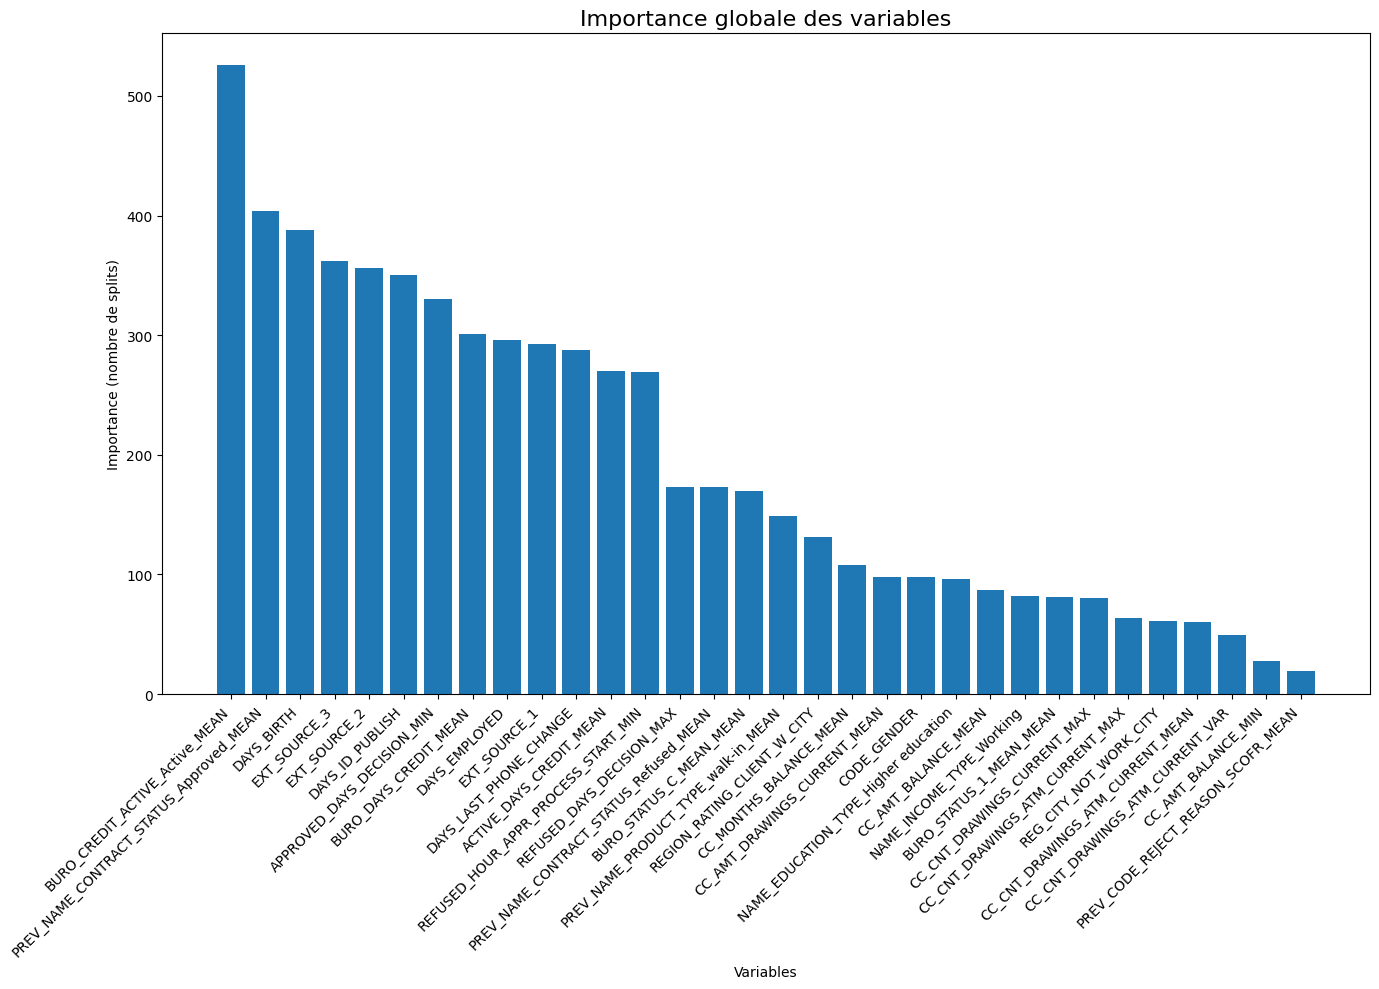

In [52]:
# Récupérer l'importance des caractéristiques pour LightGBM (importance par split ou gain)
importance = best_model.feature_importances_  # Ou bien best_model.feature_importances_['gain'] pour 'gain'

# Obtenir les noms des caractéristiques
features = X_train.columns if isinstance(X_train, pd.DataFrame) else quantitative_columns

# Trier les indices par importance
indices = np.argsort(importance)[::-1]

# Tracer l'importance des variables
plt.figure(figsize=(14, 10))
plt.title("Importance globale des variables", fontsize=16)
plt.bar(range(len(importance)), importance[indices], align="center")
plt.xticks(range(len(importance)), [features[i] for i in indices], rotation=45, ha="right")
plt.xlabel("Variables")
plt.ylabel("Importance (nombre de splits)")
plt.tight_layout()
plt.show()

Interprétation :
Ce graphique représente l'importance globale des variables dans le modèle de régression logistique. Plus la valeur absolue du coefficient est élevée, plus la variable est importante pour le modèle.
Ici, la première variable (CC_CMT_DRAWINGS_ATM_CURRENT_MEAN) a le coefficient le plus élevé (environ 10), ce qui signifie qu'elle a une forte influence positive sur la prédiction.
Inversement, certaines variables comme CC_CIT_DRAWINGS_CURRENT_MEAN ont des coefficients négatifs, indiquant qu'elles ont un effet négatif important sur la prédiction.
Le graphique permet de voir facilement quelles variables ont un rôle plus ou moins important dans le modèle. Les variables à gauche (avec des coefficients plus grands en valeur absolue) sont les plus influentes, tandis que celles à droite (avec des coefficients proches de zéro) ont un impact moindre.

#### 4.3.2. Importance locale

Visualisation de l'importance des variables, à la fois globalement et localement, à l'aide d'un graphique SHAP summary, pour interpréter le modèle de régression logistique entraîné

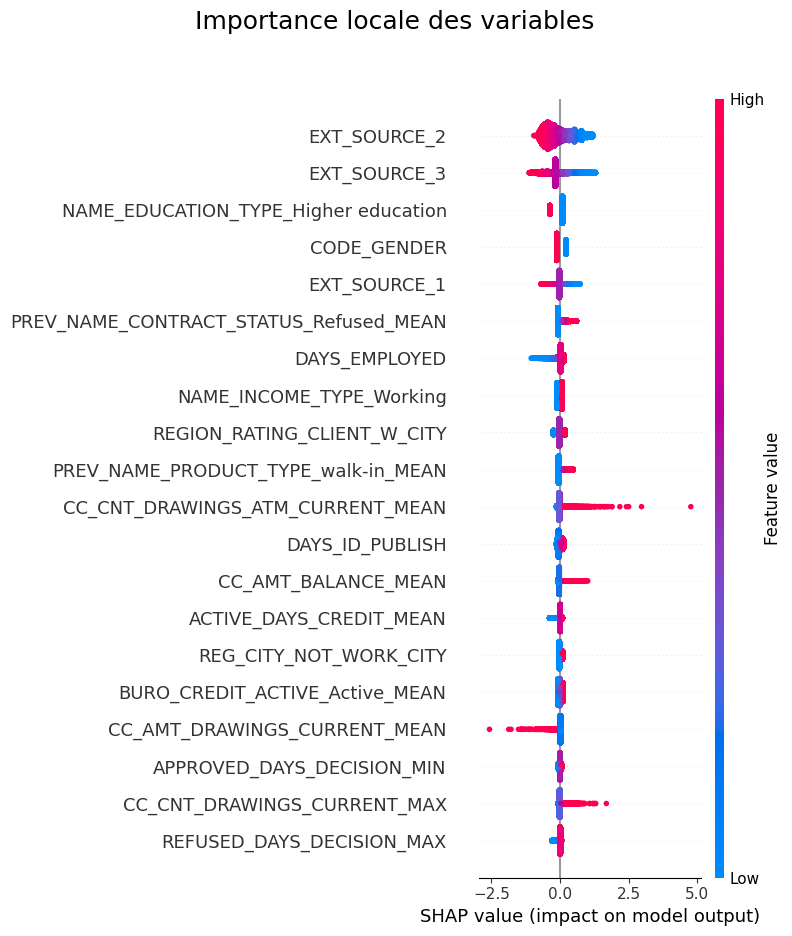

In [22]:
# Créer un explainer SHAP pour le modèle LogisticRegression
explainer = shap.LinearExplainer(best_model, X_train)  

# Calculer les valeurs SHAP pour le jeu de test
shap_values = explainer.shap_values(X_test)

# Afficher le résumé SHAP global (mélange entre importance globale et locale)
plt.figure(figsize=(10, 6))
shap.summary_plot(shap_values, X_test, feature_names=quantitative_columns, show=False)
plt.suptitle("Importance locale des variables", x=0.5, ha='center', fontsize=18)
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

Interprétation: Ce graphique montre que des variables comme EXT_SOURCE_2, EXT_SOURCE_3, et NAME_EDUCATION_TYPE_Higher education sont parmi les plus influentes dans le modèle. Les points colorés permettent de comprendre comment les valeurs spécifiques de ces variables influencent les prédictions (positivement ou négativement). En général, il aide à identifier les variables les plus critiques et comment elles affectent les prédictions à un niveau individuel

#### 4.4. Enregistrement modèle pour API

- Création d'un pipeline de prétraitement des données (imputation par la médiane et standardisation) et du modèle régression logistique avec les hyperparamètres optimaux pour la création de l'API
- Entraînement du pipeline

In [50]:
# Filtrer la ligne pour LightGBM
lgb_params_row = df_results[df_results['Model'] == 'LightGBM']
best_params_lgb = lgb_params_row['Best Params'].values[0]

# Filtrer les paramètres pour ne garder que ceux qui sont valides pour LightGBM
valid_params_lgb = {key: value for key, value in best_params_lgb.items() 
                    if key in ['learning_rate', 'n_estimators', 'max_depth', 'num_leaves', 'subsample', 'colsample_bytree']}

print(f"Valid Params for LightGBM: {valid_params_lgb}")

# Créer le pipeline avec les bons hyperparamètres
pipeline = Pipeline([
    ('scaler', StandardScaler()),  # Standardisation des données
    ('classifier', LGBMClassifier(**valid_params_lgb))  # Modèle LightGBM avec les paramètres filtrés
])

# Ajuster le pipeline sur les données d'entraînement
pipeline.fit(X_train, y_train)

# Évaluer le modèle sur le jeu de validation
y_val_pred_proba = pipeline.predict_proba(X_val)[:, 1]
auc_score = roc_auc_score(y_val, y_val_pred_proba)
print(f"AUC: {auc_score}")

# Optimisation du seuil et calcul des métriques métier
optimal_threshold, business_cost = find_optimal_threshold(pipeline, X_val, y_val)
print(f"Optimal Threshold: {optimal_threshold}, Business Cost: {business_cost}")

Valid Params for LightGBM: {'learning_rate': 0.22959818254342154, 'n_estimators': 160, 'num_leaves': 40}
[LightGBM] [Info] Number of positive: 226132, number of negative: 226132
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.094749 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 8150
[LightGBM] [Info] Number of data points in the train set: 452264, number of used features: 32
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
AUC: 0.7258708457317848
Optimal Threshold: 0.09, Business Cost: 17572


In [23]:
# Filtrer la ligne pour LogisticRegression
logreg_params_row = df_results[df_results['Model'] == 'LogisticRegression']
best_params_lr = logreg_params_row['Best Params'].values[0]

# Filtrer les paramètres pour ne garder que ceux qui sont valides pour LogisticRegression
valid_params_lr = {key: value for key, value in best_params_lr.items() 
                   if key in ['C', 'solver', 'penalty', 'max_iter']}

print(f"Valid Params for LogisticRegression: {valid_params_lr}")

# Créer le pipeline avec les bons hyperparamètres
pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),  # Imputation des valeurs manquantes
    ('scaler', MinMaxScaler()),  # Standardisation des données
    ('classifier', LogisticRegression(**valid_params_lr))  # Modèle avec les paramètres filtrés
])

# Initialiser une expérience dans MLflow
mlflow.set_experiment('logistic_regression_pipeline')

with mlflow.start_run(run_name='LogisticRegression with Best Params'):
    # Ajuster le pipeline sur les données d'entraînement
    pipeline.fit(X_train, y_train)
    
    # Évaluer le modèle sur le jeu de validation
    y_val_pred_proba = pipeline.predict_proba(X_val)[:, 1]
    auc_score = roc_auc_score(y_val, y_val_pred_proba)
    print(f"AUC: {auc_score}")

    # Optimisation du seuil et calcul des métriques métier
    optimal_threshold, business_cost = find_optimal_threshold(pipeline, X_val, y_val)
    print(f"Optimal Threshold: {optimal_threshold}, Business Cost: {business_cost}")
    
    # Enregistrer les hyperparamètres dans MLflow
    mlflow.log_params(valid_params_lr)
    
    # Enregistrer les métriques dans MLflow
    mlflow.log_metric('AUC', auc_score)
    mlflow.log_metric('Optimal Threshold', optimal_threshold)
    mlflow.log_metric('Business Cost', business_cost)
    
    # Enregistrer le pipeline dans MLflow
    mlflow.sklearn.log_model(pipeline, "logistic_regression_pipeline")

    # Finir le run
    mlflow.end_run()

print("Modèle et métriques enregistrés dans MLflow avec succès.")

Valid Params for LogisticRegression: {'C': 4.468327528535911, 'solver': 'lbfgs'}


/opt/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


AUC: 0.7421277228289095
Optimal Threshold: 0.52, Business Cost: 17000


2024/10/11 20:34:12 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Modèle et métriques enregistrés dans MLflow avec succès.


In [51]:
joblib.dump(pipeline, 'pipeline.joblib')

['pipeline.joblib']

### 5. Conclusion

L'objectif de l'entreprise "Prêt à dépenser" était de mettre en œuvre un outil de “scoring crédit” pour calculer la probabilité qu’un client rembourse son crédit, puis classifie la demande en crédit accordé ou refusé. Pour cela, plusieurs fichiers ont été transmis par l'entreprise. La première étape a été de faire du feature engineering selon un kernel modèle. Puis, un tri des variables (environ 800 variables à 32 variables) a été fait en sélectionnant les variables corrélées avec la variable cible TARGET et non corrélées entre elles. Ensuite, les données ont été prétraitées, une fonction métier a été défini, plusieurs modèles linéaire et non-linéaire ont été testé, avec une optimisation des hyperparamètres. Le modèle de regression logistique est le modèle optimal. Un tracking des expérimentations a été fait avec MLFlow. Et enfin, l'importance globale et locale des variables sur ce modèle ont été étudié. 
La prochaine étape est de mettre en oeuvre l'outil de "scoring crédit" à l'aide d'une API.